In [20]:
#We are interested in divergent hnRNPM events to figure out the cell type specificity of hnRNPM. These divergent events can be gene expression, splicing, and binding.

#We are also in events that are present in one condition but now present in another condition. Think about hnRNPM not regulating CD44 in epi but doing so in mes

#An additional filter for these events will be whether or not they occur during EMT

#On these three categories I will run GO term analyses per DAVID and GRACE

In [21]:
#need to automate go analysis with david
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_venn as mplv
import os
from math import *
from subprocess import *
import pybedtools as pbt
from glob import glob
import seaborn as sns
import statsmodels.formula.api as sm
import csv
import re
import scipy.stats as ss
csv.register_dialect("textdialect",delimiter='\t')
%matplotlib inline
mpl.rc("lines", markeredgewidth=0.5)


In [22]:
#Most of this is already in the master go analysis ipython notebook

In [23]:
ls

cc1_cc4_all_spliced_genes
cc1_cc4_and_hh5_hh6_background_genes
cc1_cc4_and_hh5_hh6_background_genes_sorted
cc1_cc4_and_hh5_hh6_background_genes_uniq
cc1_cc4_background_genes_fpkm_1*
cc1_cc4_union_vs_hh5_hh6_gene_exp.txt*
cc1_cc4_vs_hh5_hh6_splicing.txt*
david_go_analysis/
divergent hnrnpm events and go analysis.ipynb
hh5_hh6_all_spliced_genes
hh5_hh6_background_genes_fpkm_1*
hnM_EPI_gene
hnM_EPI_gene.withBG.chartReport
hnM_EPI_splice
hnM_EPI_splice.withBG.chartReport
hnM_gene_intersection
hnM_gene_intersection.withBG.chartReport
hnM_MES_gene
hnM_MES_gene.withBG.chartReport
hnM_MES_splice
hnM_MES_splice.withBG.chartReport
hnM_splice_intersection
hnM_splice_intersection.withBG.chartReport
old_stuff/
twist_all_spliced_genes
twist_background_genes_fpkm_1


In [75]:
#Load all splicing and gene expression dataframes
twist_rMATS_df_filtered = pd.read_table('../twist_rMATS_df_filtered')
cc1_cc4_rMATS_df_filtered = pd.read_table('../cc1_cc4_rMATS_df_filtered')
hh5_hh6_rMATS_df_filtered = pd.read_table('../hh5_hh6_rMATS_df_filtered')

cc1_cc2_rMATS_df_filtered = pd.read_table('../cc1_cc2_rMATS_df_filtered')

cc3_cc4_rMATS_df_filtered = pd.read_table('../cc3_cc4_rMATS_df_filtered')

twist_cuff_df_filtered = pd.read_table('../twist_cuff_df_filtered')
cc1_cc4_cuff_df_filtered = pd.read_table('../cc1_cc4_cuff_df_filtered')
hh5_hh6_cuff_df_filtered = pd.read_table('../hh5_hh6_cuff_df_filtered')

cc1_cc2_cuff_df_filtered = pd.read_table('../cc1_cc2_cuff_df_filtered')
cc3_cc4_cuff_df_filtered = pd.read_table('../cc3_cc4_cuff_df_filtered')

In [ ]:
#Filter them

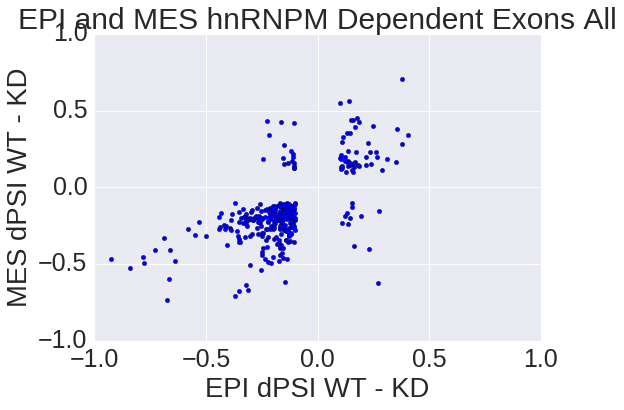

In [125]:
#Plot the divergent splicing events - by PSI
#plot epi vs mes hnM cassettes all regardless of emt.

#All events

cc1_cc4_set = set(cc1_cc4_rMATS_df_filtered.splice_id.tolist())
hh5_hh6_set = set(hh5_hh6_rMATS_df_filtered.splice_id.tolist())


epi_and_mes_hnM_intersection = pd.Series(list(cc1_cc4_set.intersection(hh5_hh6_set)))
epi_df = hh5_hh6_rMATS_df_filtered.loc[hh5_hh6_rMATS_df_filtered['splice_id'].isin(epi_and_mes_hnM_intersection)]
mes_df = cc1_cc4_rMATS_df_filtered.loc[cc1_cc4_rMATS_df_filtered['splice_id'].isin(epi_and_mes_hnM_intersection)]

#Sort

epi_df.sort_values(by='splice_id',inplace=True)
mes_df.sort_values(by='splice_id',inplace=True)

#now plot
plt.scatter(x=epi_df.IncLevelDifference,y=mes_df.IncLevelDifference)
plt.ylim(top=1,bottom=-1)
plt.xlim(left=-1,right=1)
plt.title('EPI and MES hnRNPM Dependent Exons All')
plt.ylabel('MES dPSI WT - KD')
plt.xlabel('EPI dPSI WT - KD')

# #export 
# epi_df.to_csv('divergent_hnrnpm_regulated_events/epi_hnM_dependent_all.txt',sep='\t',columns=['splice_id','IncLevelDifference'],index=False)
# mes_df.to_csv('divergent_hnrnpm_regulated_events/mes_hnM_dependent_all.txt',sep='\t',columns=['splice_id','IncLevelDifference'],index=False)

In [124]:
print(len(epi_df),len(mes_df))

(148, 148)


In [112]:
#collect the divergent splicing events
#Logic - take greater than for one sample and less than for another sample
#paste together the incleveldifference
mes_dpsi = mes_df[['splice_id','IncLevelDifference','splicing_factor_effect']]
epi_df_merge = pd.merge(epi_df,mes_dpsi,how='left',on='splice_id')

#now select the different groups
epi_hnM_includes_mes_hnM_skips = epi_df_merge[(epi_df_merge.IncLevelDifference_x > 0) & (epi_df_merge.IncLevelDifference_y < 0)]

epi_hnM_skips_mes_hnM_includes = epi_df_merge[(epi_df_merge.IncLevelDifference_x < 0) & (epi_df_merge.IncLevelDifference_y > 0)]

print(len(epi_hnM_skips_mes_hnM_includes),len(epi_hnM_includes_mes_hnM_skips))

(17, 12)


In [148]:
epi_hnM_includes_mes_hnM_skips

,splice_id,ID,GeneID,geneSymbol,chr,strand,exonStart_0base,exonEnd,upstreamES,upstreamEE,...,FDR,IncLevel1,inc_level_1_mean,IncLevel2,inc_level_2_mean,IncLevelDifference_x,splicing_factor_effect_x,ens_gene,IncLevelDifference_y,splicing_factor_effect_y
13,chr11:117077782-117077876:117078369-117078451:...,81043,ENSG00000160613.12_2,PCSK7,chr11,-,117078369,117078451,117077782,117077876,...,6.305315e-06,0.283,0.283,0.118,0.118,0.165,enhance,ENSG00000160613,-0.384,silence
42,chr11:95511985-95512121:95512241-95512299:9551...,18259,ENSG00000077458.12_1,FAM76B,chr11,-,95512241,95512299,95511985,95512121,...,3.457806e-04,0.718,0.718,0.524,0.524,0.194,enhance,ENSG00000077458,-0.185,silence
53,chr12:76844630-76844768:76853638-76853675:7688...,43961,ENSG00000091039.16_2,OSBPL8,chr12,-,76853638,76853675,76844630,76844768,...,1.337836e-05,0.433,0.433,0.289,0.289,0.144,enhance,ENSG00000091039,-0.200,silence
55,chr12:9462934-9463037:9463736-9463886:9464145-...,30280,ENSG00000111788.10_1,RP11-22B23.1,chr12,+,9463736,9463886,9462934,9463037,...,6.891620e-03,0.826,0.826,0.555,0.555,0.271,enhance,ENSG00000111788,-0.626,silence
114,chr17:65871035-65871136:65882243-65882432:6588...,84149,ENSG00000171634.16_2,BPTF,chr17,+,65882243,65882432,65871035,65871136,...,7.593176e-03,0.830,0.830,0.694,0.694,0.136,enhance,ENSG00000171634,-0.242,silence
123,chr19:14810010-14810093:14812395-14812709:1481...,69211,ENSG00000160961.11_1,ZNF333,chr19,+,14812395,14812709,14810010,14810093,...,5.772372e-05,0.491,0.491,0.214,0.214,0.277,enhance,ENSG00000160961,-0.152,silence
156,chr1:78050201-78050340:78105133-78105287:78107...,84007,ENSG00000036549.12_2,ZZZ3,chr1,-,78105133,78105287,78050201,78050340,...,1.040004e-02,0.991,0.991,0.881,0.881,0.110,enhance,ENSG00000036549,-0.233,silence
160,chr1:95699769-95699871:95702903-95703016:95705...,13836,ENSG00000122481.16_2,RWDD3,chr1,+,95702903,95703016,95699769,95699871,...,5.375031e-03,0.852,0.852,0.697,0.697,0.155,enhance,ENSG00000122481,-0.128,silence
173,chr20:47770469-47770608:47782533-47782822:4780...,59226,ENSG00000124214.19_2,STAU1,chr20,-,47782533,47782822,47770469,47770608,...,1.337423e-04,0.682,0.682,0.454,0.454,0.228,enhance,ENSG00000124214,-0.405,silence
272,chr5:131554237-131554337:131562778-131562914:1...,24144,ENSG00000072682.18_2,P4HA2,chr5,-,131562778,131562914,131554237,131554337,...,5.477167e-10,0.764,0.764,0.640,0.640,0.124,enhance,ENSG00000072682,-0.186,silence


In [149]:
epi_hnM_skips_mes_hnM_includes

,splice_id,ID,GeneID,geneSymbol,chr,strand,exonStart_0base,exonEnd,upstreamES,upstreamEE,...,FDR,IncLevel1,inc_level_1_mean,IncLevel2,inc_level_2_mean,IncLevelDifference_x,splicing_factor_effect_x,ens_gene,IncLevelDifference_y,splicing_factor_effect_y
25,chr11:35211381-35211612:35219667-35219793:3522...,17107,ENSG00000026508.16_2,CD44,chr11,+,35219667,35219793,35211381,35211612,...,0.000000e+00,0.723,0.723,0.836,0.836,-0.113,silence,ENSG00000026508,0.173,enhance
50,chr12:32890038-32890095:32890798-32890876:3289...,7725,ENSG00000087470.17_1,DNM1L,chr12,+,32890798,32890876,32890038,32890095,...,2.539262e-03,0.610,0.610,0.716,0.716,-0.106,silence,ENSG00000087470,0.160,enhance
52,chr12:62959016-62959160:62959793-62959811:6296...,66710,ENSG00000061987.14_1,MON2,chr12,+,62959793,62959811,62959016,62959160,...,5.497831e-08,0.325,0.325,0.544,0.544,-0.219,silence,ENSG00000061987,0.344,enhance
64,chr13:41905409-41905505:41910785-41910892:4193...,36625,ENSG00000172766.18_1,NAA16,chr13,+,41910785,41910892,41905409,41905505,...,1.801533e-02,0.671,0.671,0.898,0.898,-0.227,silence,ENSG00000172766,0.434,enhance
72,chr14:21543490-21543658:21543781-21543924:2154...,52153,ENSG00000165801.9_1,ARHGEF40,chr14,+,21543781,21543924,21543490,21543658,...,1.152063e-02,0.766,0.766,0.928,0.928,-0.162,silence,ENSG00000165801,0.426,enhance
73,chr14:21543490-21543658:21543803-21543924:2154...,52151,ENSG00000165801.9_1,ARHGEF40,chr14,+,21543803,21543924,21543490,21543658,...,5.005021e-03,0.848,0.848,0.960,0.960,-0.112,silence,ENSG00000165801,0.220,enhance
77,chr14:39788412-39788495:39790131-39790260:3979...,15406,ENSG00000258941.3_2,RP11-407N17.3,chr14,+,39790131,39790260,39788412,39788495,...,4.633886e-07,0.361,0.361,0.512,0.512,-0.151,silence,ENSG00000258941,0.277,enhance
86,chr14:89338673-89338796:89341369-89341453:8934...,23565,ENSG00000165533.18_2,TTC8,chr14,+,89341369,89341453,89338673,89338796,...,1.039853e-06,0.849,0.849,0.953,0.953,-0.104,silence,ENSG00000165533,0.125,enhance
134,chr19:7968769-7968953:7970692-7970740:7974639-...,38895,ENSG00000076984.17_1,MAP2K7,chr19,+,7970692,7970740,7968769,7968953,...,1.717509e-06,0.246,0.246,0.493,0.493,-0.247,silence,ENSG00000076984,0.182,enhance
148,chr1:167973770-167974031:167985018-167985189:1...,25628,ENSG00000143164.15_1,DCAF6,chr1,+,167985018,167985189,167973770,167974031,...,2.153519e-05,0.155,0.155,0.274,0.274,-0.119,silence,ENSG00000143164,0.240,enhance


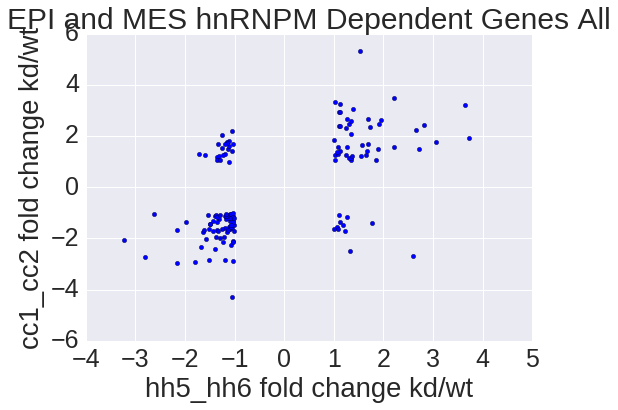

In [123]:
#Plot the divergent genes - use fold change which should be robust to FPKM
#All events

#Can't do cc1_and_cc4_because it is not properly combined

#This is CC1_CC2

cc1_cc2_set = set(cc1_cc2_cuff_df_filtered.ens_gene.tolist())

hh5_hh6_set = set(hh5_hh6_cuff_df_filtered.ens_gene.tolist())


epi_and_mes_hnM_intersection = pd.Series(list(cc1_cc2_set.intersection(hh5_hh6_set)))

epi_df = hh5_hh6_cuff_df_filtered.loc[hh5_hh6_cuff_df_filtered['ens_gene'].isin(epi_and_mes_hnM_intersection)]

mes_df = cc1_cc2_cuff_df_filtered.loc[cc1_cc2_cuff_df_filtered['ens_gene'].isin(epi_and_mes_hnM_intersection)]

#Sort

epi_df.sort_values(by='ens_gene',inplace=True)
mes_df.sort_values(by='ens_gene',inplace=True)

#now plot
plt.scatter(x=epi_df.log2_fold_change,y=mes_df.log2_fold_change)
# plt.ylim(top=1,bottom=-1)
# plt.xlim(left=-1,right=1)
plt.title('EPI and MES hnRNPM Dependent Genes All')
plt.ylabel('cc1_cc2 fold change kd/wt')
plt.xlabel('hh5_hh6 fold change kd/wt')

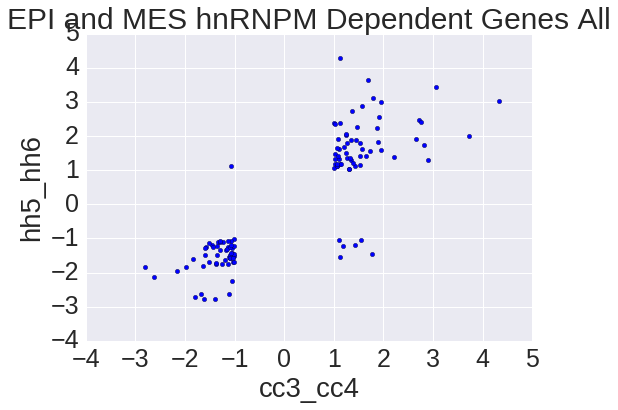

In [122]:
#Plot the divergent genes - use fold change which should be robust to FPKM
#All events

#Can't do cc1_and_cc4_because it is not properly combined

#This is CC3_CC4

cc3_cc4_set = set(cc3_cc4_cuff_df_filtered.ens_gene.tolist())

hh5_hh6_set = set(hh5_hh6_cuff_df_filtered.ens_gene.tolist())


epi_and_mes_hnM_intersection = pd.Series(list(cc3_cc4_set.intersection(hh5_hh6_set)))

epi_df = hh5_hh6_cuff_df_filtered.loc[hh5_hh6_cuff_df_filtered['ens_gene'].isin(epi_and_mes_hnM_intersection)]

mes_df = cc3_cc4_cuff_df_filtered.loc[cc3_cc4_cuff_df_filtered['ens_gene'].isin(epi_and_mes_hnM_intersection)]

#Sort

epi_df.sort_values(by='ens_gene',inplace=True)
mes_df.sort_values(by='ens_gene',inplace=True)

#now plot
plt.scatter(x=epi_df.log2_fold_change,y=mes_df.log2_fold_change)
# plt.ylim(top=1,bottom=-1)
# plt.xlim(left=-1,right=1)
plt.title('EPI and MES hnRNPM Dependent Genes All')
plt.ylabel('hh5_hh6_fold change kd/wt')
plt.xlabel('cc3_cc4 fold change kd/wt')

In [86]:
print(len(epi_df),len(mes_df))

(125, 123)


In [141]:
#write a function to go into the david output and collect the data for the 3 bar graphs and then plot
#How am I going to do this. Pull everything out as a dataframe
def david_bar_graph(david_sample_1_file,david_sample_2_file,david_intersection_file,sample_1,sample_2,go_term_id,sig_cutoff):
    '''This actually just takes 3 david files and then outputs the bar graph for each of them'''
    sample_1_only = pd.read_csv(david_sample_1_file,sep='\t')
    sample_2_only = pd.read_csv(david_sample_2_file,sep='\t')
    intersection = pd.read_csv(david_intersection_file,sep='\t')

    #collect only the GOTERM_BP_DIRECT
    def collect_id_of_interest(id_of_interest,dataframe):
        dataframe = dataframe[dataframe.Category == id_of_interest]
        return dataframe

    sample_1_only = collect_id_of_interest(go_term_id,sample_1_only)
    sample_2_only = collect_id_of_interest(go_term_id,sample_2_only)
    intersection = collect_id_of_interest(go_term_id,intersection)

    #now need to filter by a neg_log_p value
    def neg_log_p_and_filter_go(cutoff,dataframe):
        dataframe['neglogP'] = dataframe.apply(lambda row: -1*log(row['Pvalue'],10),axis=1)
        dataframe = dataframe[dataframe.neglogP > cutoff]
        #set a top 10
        dataframe = dataframe.head(10)
        return dataframe

    sample_1_only = neg_log_p_and_filter_go(sig_cutoff,sample_1_only)
    sample_2_only = neg_log_p_and_filter_go(sig_cutoff,sample_2_only)
    intersection = neg_log_p_and_filter_go(sig_cutoff,intersection)
    
    sample_1_only['sample'] = sample_1
    sample_2_only['sample'] = sample_2
    intersection['sample'] = sample_1+'\nand '+sample_2
    
    combined = pd.concat([sample_1_only,sample_2_only,intersection],ignore_index=True)
    
    #how could I plot side by side?
    #try an sns barplot after concat
    sns.set(font_scale=2.5)
    plt.figure(figsize=(10,15))
    sns.barplot(x='neglogP',y='Term',hue='sample',data=combined,orient='h')
    plt.legend(bbox_to_anchor=(1.75,1))

    #now blot a bar graph for each one
#     fig,ax = plt.subplots(3,1,figsize=(10,20),sharey=False,sharex=True)
#     sample_1_only.plot.barh(x='Term',y='neglogP',fontsize=15,ax=ax[0],label=sample_1+'_only',color='r')
#     sample_2_only.plot.barh(x='Term',y='neglogP',fontsize=15,ax=ax[1],label=sample_2+'_only',color='g')
#     intersection.plot.barh(x='Term',y='neglogP',fontsize=15,ax=ax[2],label=sample_1+'_and_'+sample_2,color='y')
        
    #add tables
#     from pandas.tools.plotting import table
#     table(ax[0],sample_1_only[['Count','%']],loc='right')
    
    #Figure out how to set a label with how many genes there are in each go term



In [ ]:
#Remember for all these GO it is cutoff dependent. I am using 2 fold change in gene expression, 0.1 delta psi in splicing with FDR 0.05

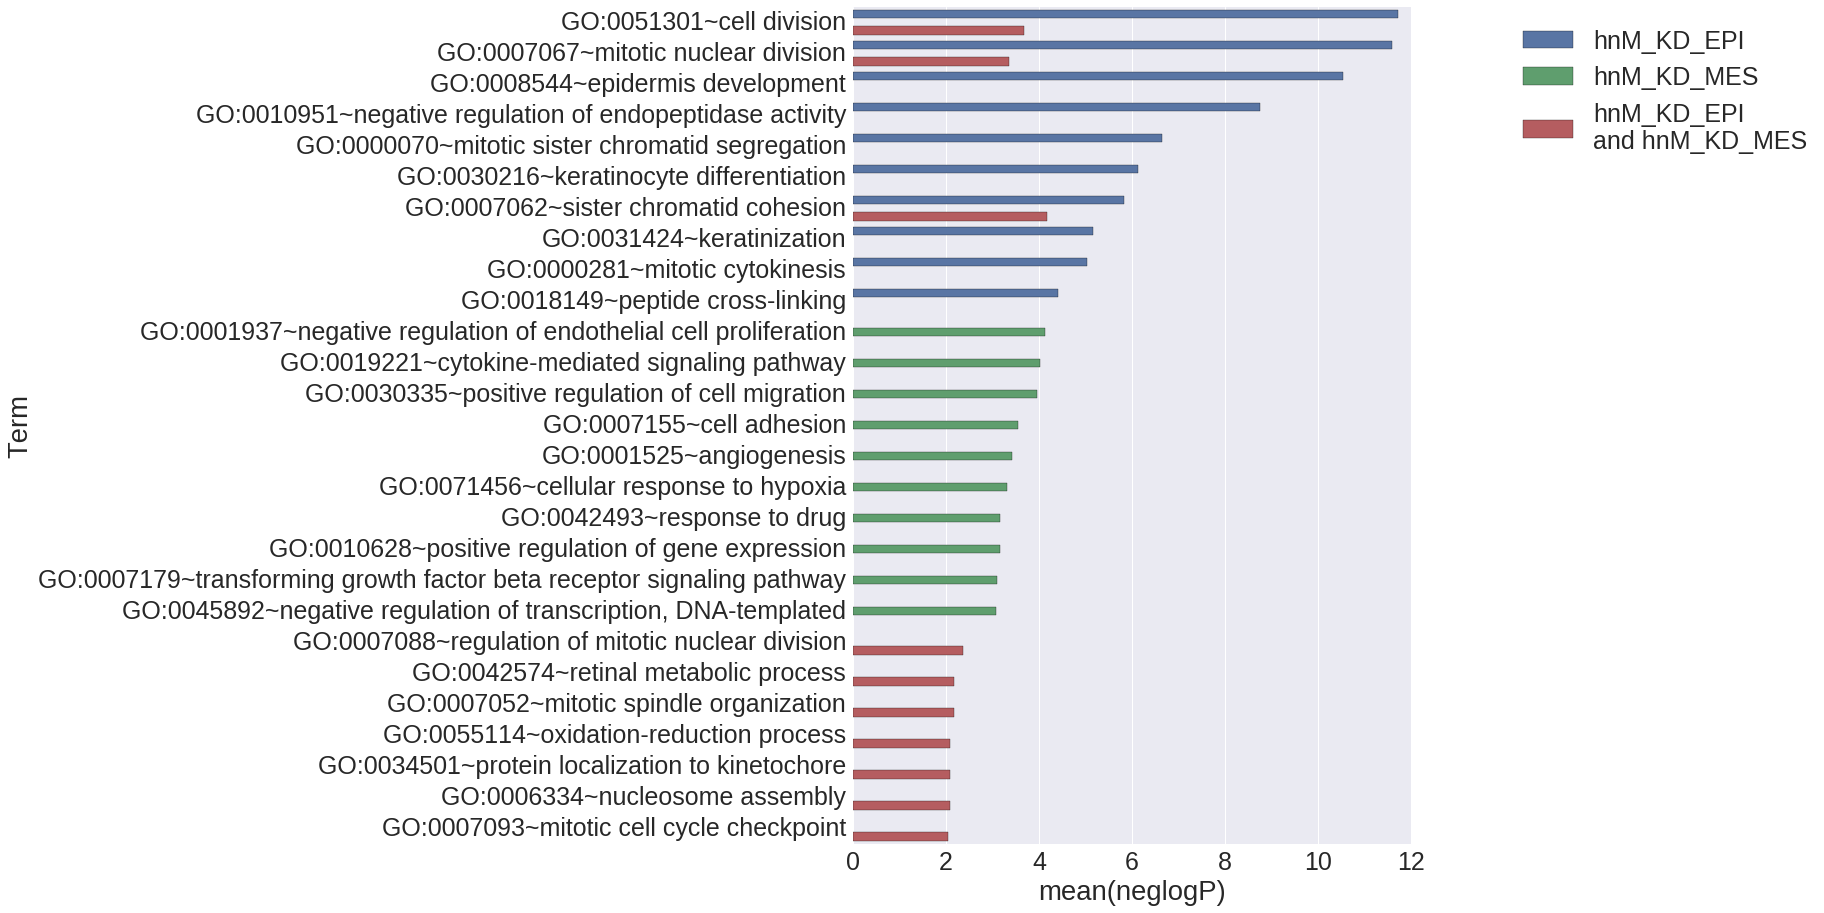

In [151]:
#compare hnRNPM genes - with background from sample specific
#The mes is somewhat distinct
hnM_epi_gene = 'david_go_analysis/gene_sample_specific_background/hnM_EPI_gene.withBG.chartReport'
hnM_mes_gene = 'david_go_analysis/gene_sample_specific_background/hnM_MES_gene.withBG.chartReport'
hnM_gene_intersection = 'david_go_analysis/gene_sample_specific_background/hnM_gene_intersection.withBG.chartReport'
david_bar_graph(hnM_epi_gene,hnM_mes_gene,hnM_gene_intersection,'hnM_KD_EPI','hnM_KD_MES','GOTERM_BP_DIRECT',1)

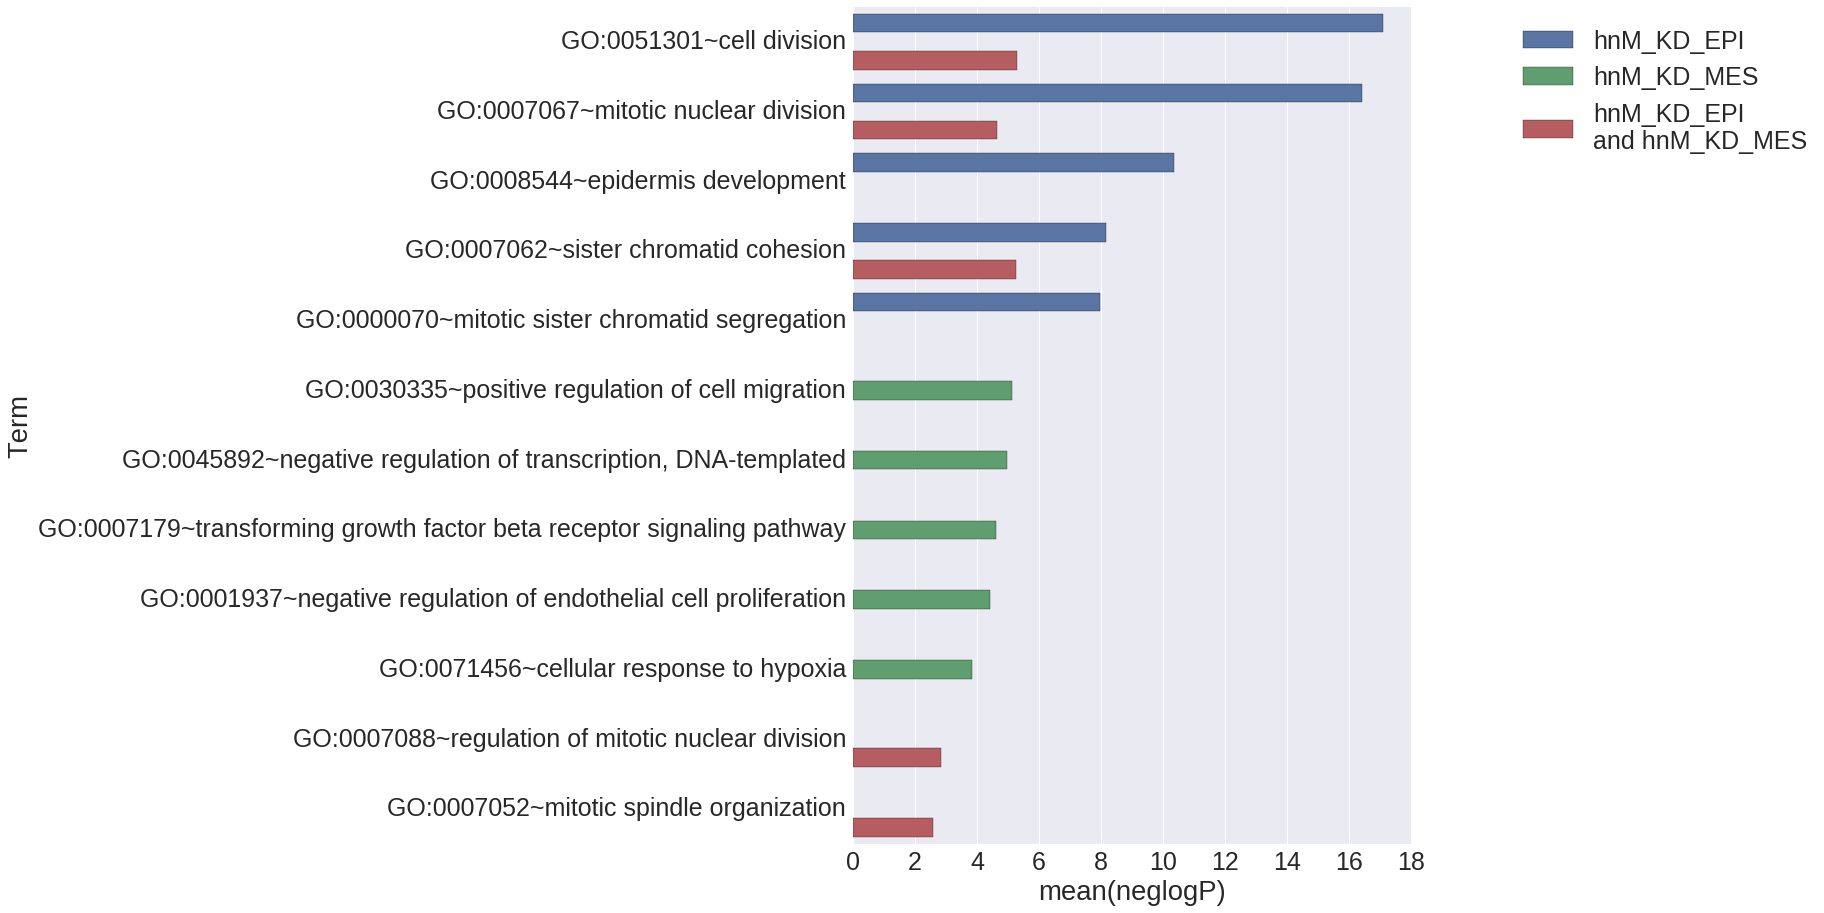

In [120]:
#compare hnRNPM genes - withOUT background
#The Pvalue just gets a little smaller
hnM_epi_gene = 'hnM_EPI_gene.chartReport'
hnM_mes_gene = 'hnM_MES_gene.chartReport'
hnM_gene_intersection = 'hnM_gene_intersection.chartReport'
david_bar_graph(hnM_epi_gene,hnM_mes_gene,hnM_gene_intersection,'hnM_KD_EPI','hnM_KD_MES','GOTERM_BP_DIRECT',1)

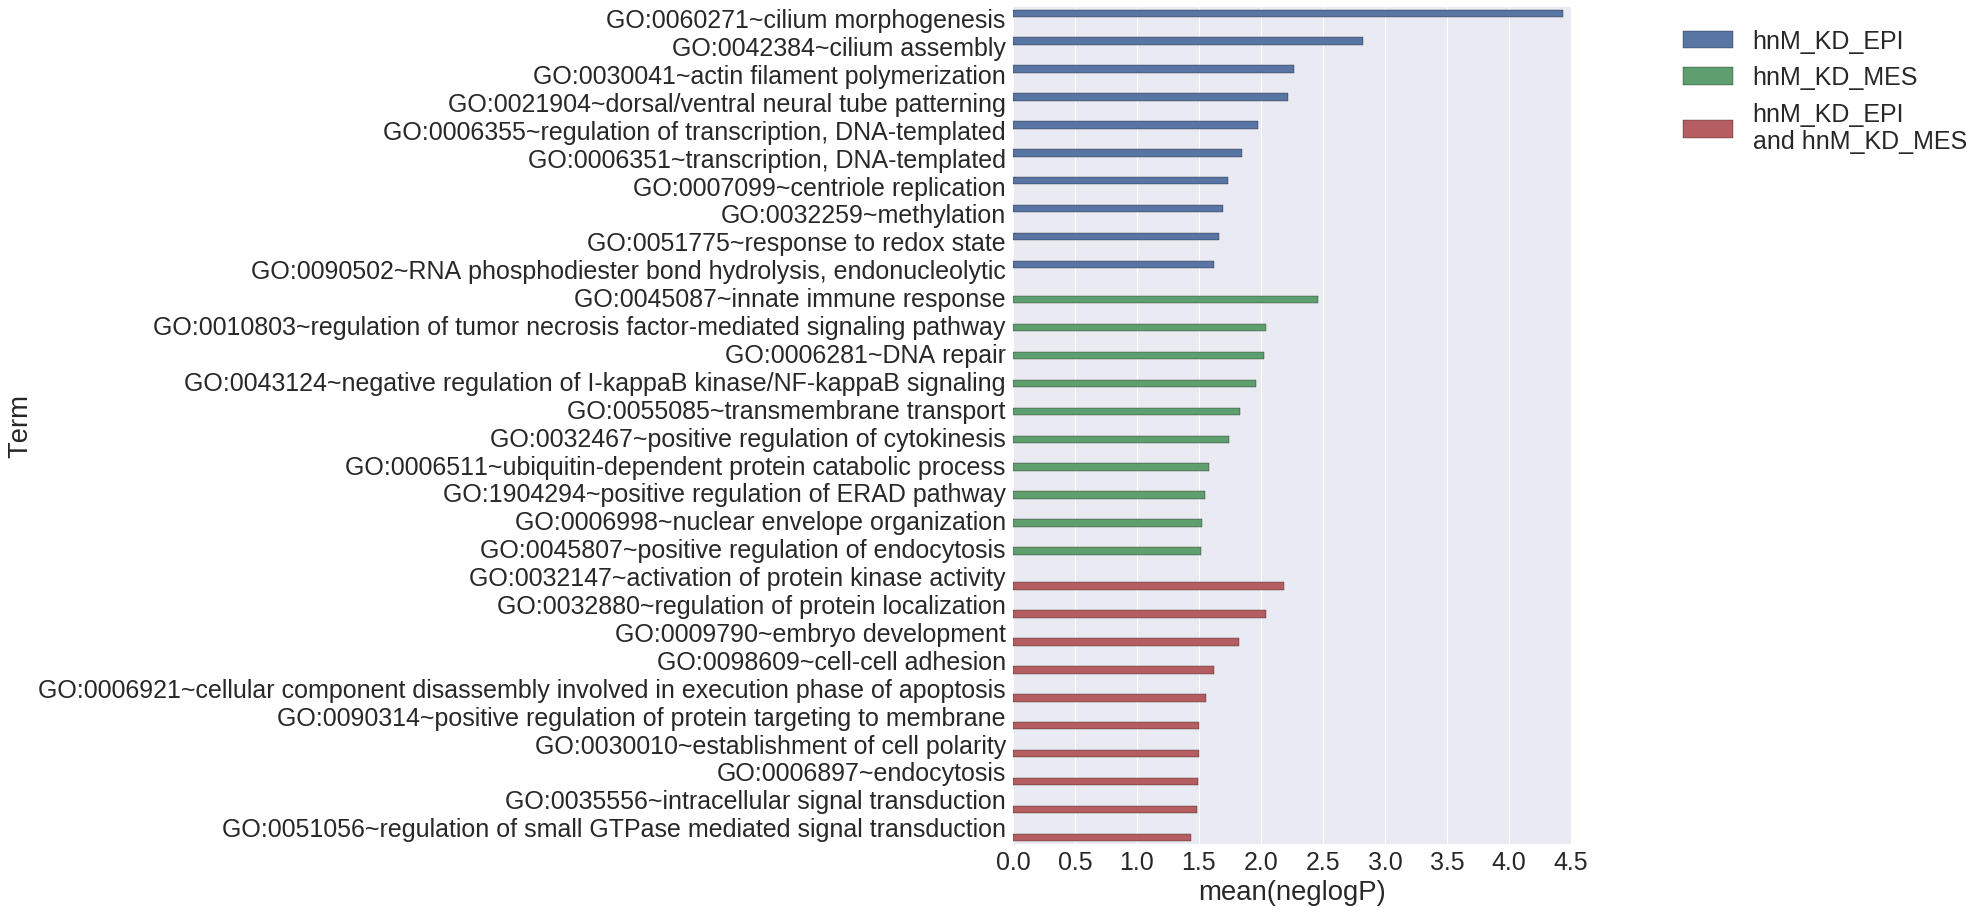

In [150]:
#compare hnRNPM splice - with HMLE and 231 expressed genes background
hnM_epi_splice = 'david_go_analysis/spliced_sample_specific_background/hnM_EPI_splice.withBG.chartReport'
hnM_mes_splice = 'david_go_analysis/spliced_sample_specific_background/hnM_MES_splice.withBG.chartReport'
hnM_splice_intersection = 'david_go_analysis/spliced_sample_specific_background/hnM_splice_intersection.withBG.chartReport'
david_bar_graph(hnM_epi_splice,hnM_mes_splice,hnM_splice_intersection,'hnM_KD_EPI','hnM_KD_MES','GOTERM_BP_DIRECT',1)

In [127]:
#Do hnRNPM differentially bound genes
clip_df = pd.read_table('../hnM_DMSO_TAM_master_dataframe_gene_expression_normalized_1nt')

In [128]:
clip_df.head()

,cluster_id,chrom,start,end,ens_gene,blank,strand,hnM_DMSO,hnM_TAM,hnM_DMSO_1,...,external_gene_name,biotype,twist_d0_fpkm_1,twist_d14_fpkm_1,log2ratio_fpkm_d14_d0,hnM_DMSO_clip_gene_fpkm_norm,hnM_TAM_clip_gene_fpkm_norm,hnM_DMSO_clip_gene_fpkm_norm_1,hnM_TAM_clip_gene_fpkm_norm_1,log2ratio_hnM_TAM_DMSO_clip_gene_fpkm_norm
0,chr1:251639-251640,chr1,251639,251640,ENSG00000228463,0,-,6.521757,0.000000,7.521757,...,AP006222.2,lincRNA,1.040763,1.117389,0.102490,6.266323,0.000000,7.266323,1.000000,-2.861225
1,chr1:251646-251647,chr1,251646,251647,ENSG00000228463,0,-,2.898558,0.000000,3.898558,...,AP006222.2,lincRNA,1.040763,1.117389,0.102490,2.785032,0.000000,3.785032,1.000000,-1.920306
2,chr1:564514-564515,chr1,564514,564515,ENSG00000225972,0,+,0.000000,5.691002,1.000000,...,MTND1P23,unprocessed_pseudogene,9.666940,27.279600,1.496691,0.000000,0.208618,1.000000,1.208618,0.273358
3,chr1:564595-564596,chr1,564595,564596,ENSG00000225972,0,+,5.072477,0.000000,6.072477,...,MTND1P23,unprocessed_pseudogene,9.666940,27.279600,1.496691,0.524724,0.000000,1.524724,1.000000,-0.608548
4,chr1:564722-564723,chr1,564722,564723,ENSG00000225972,0,+,0.000000,19.349407,1.000000,...,MTND1P23,unprocessed_pseudogene,9.666940,27.279600,1.496691,0.000000,0.709300,1.000000,1.709300,0.773405


/home/sam/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:56: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/home/sam/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:58: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/home/sam/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:60: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


NameError: name 'ax' is not defined

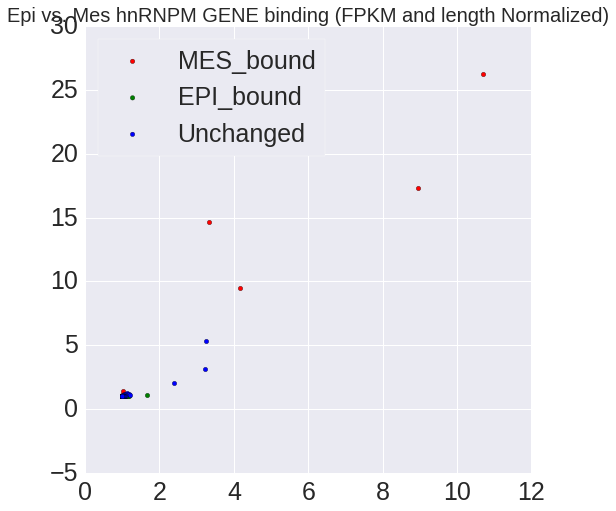

In [135]:
# %%time
#Need to add the gene level analysis from the clipper_clusters_analysis
#Here it is below
#------------------------------------------------
#GROUPBY WITH GENES
#Here we figure out how to obtain the genes with their expression normalized change in binding - this is the key dataset

#groupby = the split,apply,combine strategy for data analysis
#Here I will obtain the sums by FPKM for the expressed genes after normalization   
#also make sure you keep the FPKM for the gene as wells
gene_group = clip_df.groupby('ens_gene')
hnM_DMSO_clip_gene_fpkm_norm_counts = gene_group.hnM_DMSO_clip_gene_fpkm_norm.aggregate(np.sum)
hnM_TAM_clip_gene_fpkm_norm_counts = gene_group.hnM_TAM_clip_gene_fpkm_norm.aggregate(np.sum)
gene_length = gene_group.gene_length.aggregate(np.mean)
twist_d0_fpkm_1 = gene_group.twist_d0_fpkm_1.aggregate(np.mean)
twist_d14_fpkm_1 = gene_group.twist_d14_fpkm_1.aggregate(np.mean)
log2ratio_fpkm_d14_d0 = gene_group.log2ratio_fpkm_d14_d0.aggregate(np.mean)

#put these counts into a dataframe so you can calculate the log2 ratio

gene_fpkm_norm_counts = pd.concat([hnM_DMSO_clip_gene_fpkm_norm_counts, hnM_TAM_clip_gene_fpkm_norm_counts,gene_length,twist_d0_fpkm_1,twist_d14_fpkm_1,log2ratio_fpkm_d14_d0], axis=1).reset_index()

#Now you have to normalize by the gene length
gene_fpkm_norm_counts['hnM_DMSO_clip_gene_length_fpkm_norm'] = gene_fpkm_norm_counts.apply(lambda row: row['hnM_DMSO_clip_gene_fpkm_norm'] / row['gene_length'],axis=1)
gene_fpkm_norm_counts['hnM_TAM_clip_gene_length_fpkm_norm'] = gene_fpkm_norm_counts.apply(lambda row: row['hnM_TAM_clip_gene_fpkm_norm'] / row['gene_length'],axis=1)

#add some pseudocount columns for plotting
#this is just the pseudocount for plotting to make sure everything is 1
pseudocount = 1
gene_fpkm_norm_counts['hnM_DMSO_clip_gene_length_fpkm_norm_1'] = gene_fpkm_norm_counts.apply(lambda row: row['hnM_DMSO_clip_gene_length_fpkm_norm']+pseudocount,axis=1)
gene_fpkm_norm_counts['hnM_TAM_clip_gene_length_fpkm_norm_1'] = gene_fpkm_norm_counts.apply(lambda row: row['hnM_TAM_clip_gene_length_fpkm_norm']+pseudocount,axis=1)

#This is the key pseudocount to make sure you include highly expressed genes that have a very low pseudocount value
#VERY IMPORTANT PSEUDOCOUNT HERE - MAKE SURE IT IS 10 FOLD BELOW THE MINIMUM VALUE
#minimum value is 8e-9, so do 1e-10
#Calculate log2 ratio,make sure to add pseudocount in case genes have no value
pseudocount = 1e-10
gene_fpkm_norm_counts['log2ratio_hnM_TAM_DMSO_clip_gene_length_fpkm_norm'] = gene_fpkm_norm_counts.apply(lambda row:(log(row['hnM_TAM_clip_gene_length_fpkm_norm']+pseudocount,2)-log(row['hnM_DMSO_clip_gene_length_fpkm_norm']+pseudocount,2)),axis=1)

#add in the external gene name and biotype
#load the file
gene_name_and_biotype_df = pd.read_csv('../GO_analysis/ensembl_gene_id_external_gene_names_biotype',sep='\t',names=['ens_gene','external_gene_name','biotype'])
#do a left merge on ens_gene, but make sure to include the na values
gene_fpkm_norm_counts_and_names = pd.merge(gene_fpkm_norm_counts,gene_name_and_biotype_df,on='ens_gene',how='left')

#ONLY LOOK AT PROTEIN CODING GENES... NON PROTEIN CODING GENES ARE TOO SKEWED
# gene_fpkm_norm_counts_and_names = gene_fpkm_norm_counts_and_names[gene_fpkm_norm_counts_and_names.biotype == 'protein_coding']

#Now split this gene_fpkm_norm_counts by log2fold change in binding and save in the GO folder

tam_bound = gene_fpkm_norm_counts_and_names.log2ratio_hnM_TAM_DMSO_clip_gene_length_fpkm_norm >= 1
dmso_bound = gene_fpkm_norm_counts_and_names.log2ratio_hnM_TAM_DMSO_clip_gene_length_fpkm_norm <= -1
non_bound = gene_fpkm_norm_counts_and_names.log2ratio_hnM_TAM_DMSO_clip_gene_length_fpkm_norm.abs() <= 1

subset_tam = gene_fpkm_norm_counts_and_names[tam_bound]
subset_tam.sort(columns='log2ratio_hnM_TAM_DMSO_clip_gene_length_fpkm_norm',ascending=False,inplace=True,axis=0)
subset_dmso = gene_fpkm_norm_counts_and_names[dmso_bound]
subset_dmso.sort(columns='log2ratio_hnM_TAM_DMSO_clip_gene_length_fpkm_norm',ascending=True,inplace=True,axis=0)
subset_non = gene_fpkm_norm_counts_and_names[non_bound]
subset_non.sort(columns='log2ratio_hnM_TAM_DMSO_clip_gene_length_fpkm_norm',ascending=False,inplace=True,axis=0)

subset_tam.to_csv('tam_bound_genes.txt',index=False,na_rep='NaN',sep='\t')
subset_tam.ens_gene.to_csv('tam_bound_genes_ensg_only.txt',index=False)
subset_dmso.to_csv('dmso_bound_genes.txt',index=False,na_rep='NaN',sep='\t')
subset_dmso.ens_gene.to_csv('dmso_bound_genes_ensg_only.txt',index=False)
subset_non.to_csv('non_bound_genes.txt',index=False,na_rep='NaN',sep='\t')
subset_non.ens_gene.to_csv('non_bound_genes_ensg_only.txt',index=False)

# #also need the background gene list of genes expressed in each cell type
# epi_expressed_df = twist_gene_exp_df[twist_gene_exp_df.twist_d0_fpkm >= 5]
# epi_expressed_genes = epi_expressed_df[['ens_gene','gene']]
# epi_expressed_genes.ens_gene.to_csv('epi_expressed_genes_ensg_only.txt',index=False)
# mes_expressed_df = twist_gene_exp_df[twist_gene_exp_df.twist_d14_fpkm >= 5]
# mes_expressed_genes = mes_expressed_df[['ens_gene','gene']]
# mes_expressed_genes.ens_gene.to_csv('mes_expressed_genes_ensg_only.txt',index=False)

#plot the genes as well
scalar = 1

fig = plt.figure(figsize=(8,8),edgecolor='black')
# ax = plt.gca()
plt.scatter(subset_tam.hnM_DMSO_clip_gene_length_fpkm_norm_1*scalar,subset_tam.hnM_TAM_clip_gene_length_fpkm_norm_1*scalar,label='MES_bound',c='red')
plt.scatter(subset_dmso.hnM_DMSO_clip_gene_length_fpkm_norm_1*scalar,subset_dmso.hnM_TAM_clip_gene_length_fpkm_norm_1*scalar,label='EPI_bound',c='green')
plt.scatter(subset_non.hnM_DMSO_clip_gene_length_fpkm_norm_1*scalar,subset_non.hnM_TAM_clip_gene_length_fpkm_norm_1*scalar,label='Unchanged',c='blue')
plt.legend(loc='upper left',frameon=True)
plt.title("Epi vs. Mes hnRNPM GENE binding (FPKM and length Normalized)",fontsize='20',)
# ax.set_yscale('log',basey=100)
# ax.set_xscale('log',basex=100)
ax.set_yscale('linear')
ax.set_xscale('linear')
# ax.set_ylim(bottom = 1e-1,top=1e1)
# ax.set_xlim(left = 1e-1,right=1e1)
ax.set_xlabel('hnRNPM Epithlelial Binding (Arbitrary Units)',fontsize='20')
ax.set_ylabel('hnRNPM Mesenchymal Binding( Arbitrary Units)',fontsize='20')
# ticks=[1e-2,1e-1,1e0,1e1,1e2,1e3,1e4,1e5]
# ax.set_xticklabels(ticks,fontsize='15',)
# ax.set_yticklabels(ticks,fontsize='15')
fig.savefig('epi_vs_mes_hnM_GENE_binding_fpkm_normalized_scatter',format='png',dpi=300)

#print how much is in each group
print('Total Number of Genes',len(gene_fpkm_norm_counts_and_names))
print('Mes Bound Genes',len(subset_tam))
print('Epi Bound Genes',len(subset_dmso))
print('Unchanged Genes',len(subset_non))


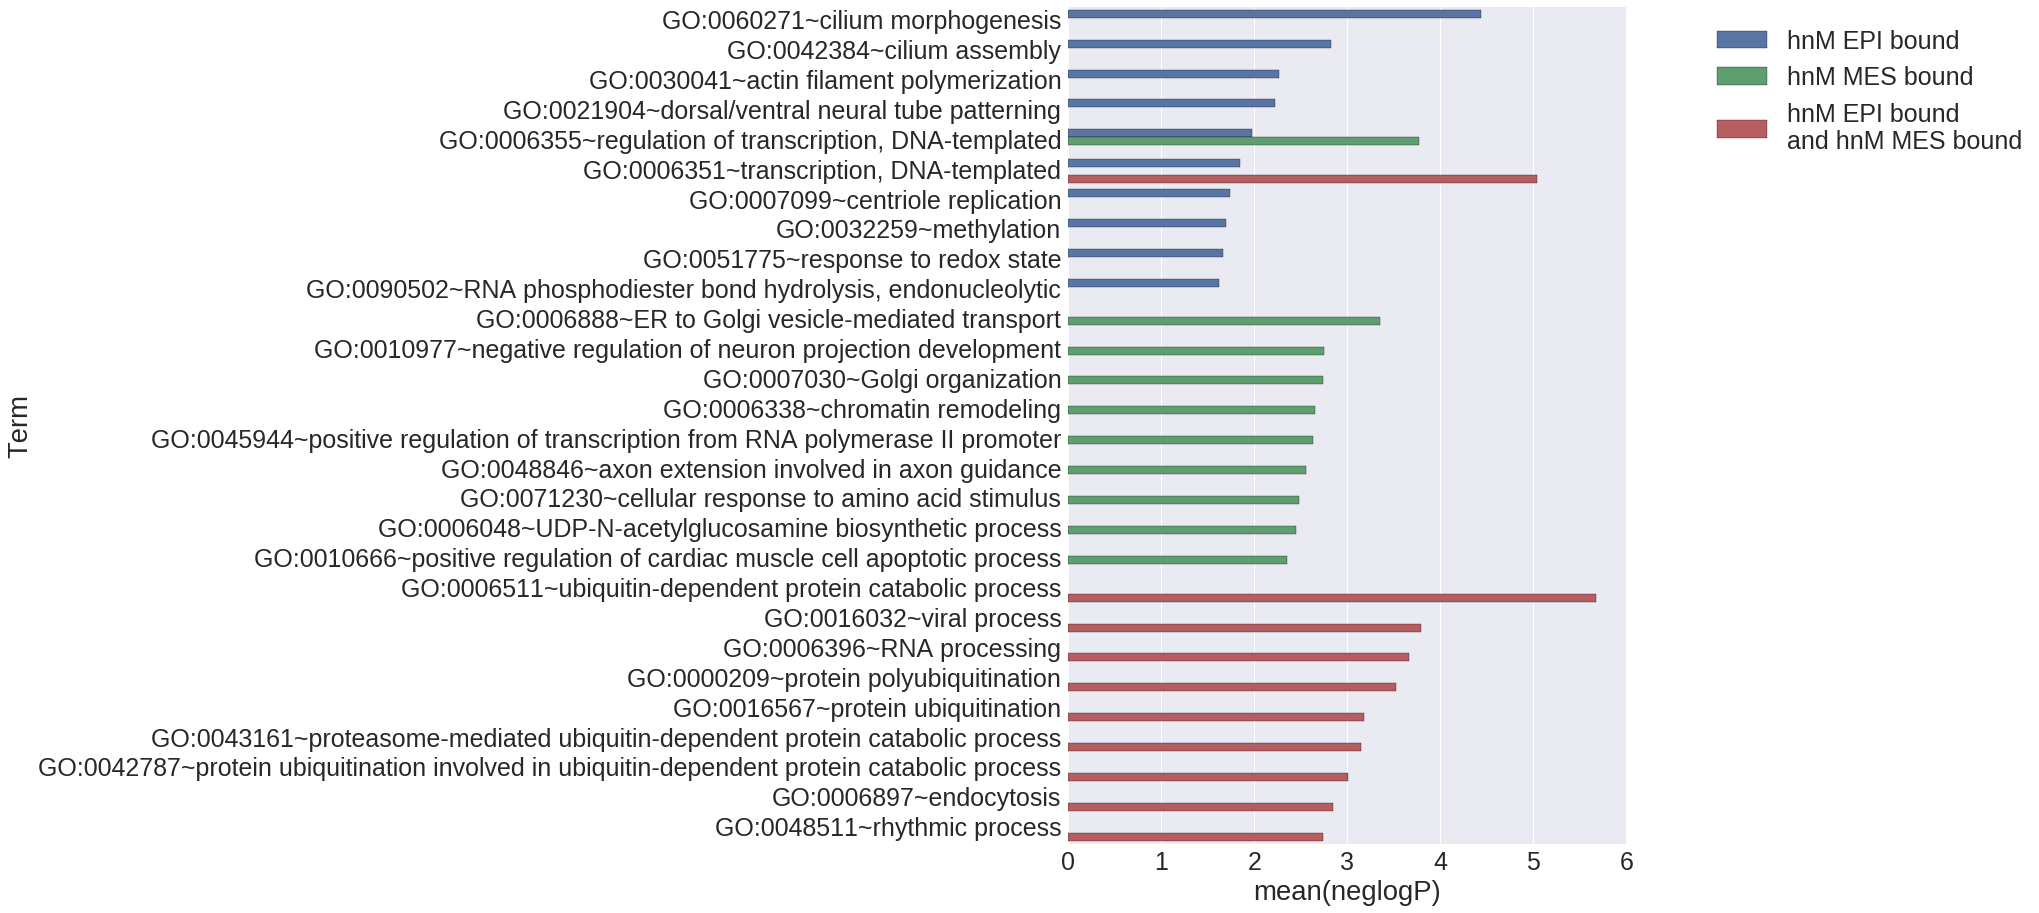

In [152]:
#hnRNPM Differentially Bound Genes with Twist-ER backgrounds
hnM_epi_bound = 'david_go_analysis/differentially_bound_genes/dmso_bound_genes_ensg_only.txt.withBG.chartReport'
hnM_mes_splice = 'david_go_analysis/differentially_bound_genes/tam_bound_genes_ensg_only.txt.withBG.chartReport'
hnM_splice_intersection = 'david_go_analysis/differentially_bound_genes/non_bound_genes_ensg_only.txt.withBG.chartReport'
david_bar_graph(hnM_epi_splice,hnM_mes_splice,hnM_splice_intersection,'hnM EPI bound','hnM MES bound','GOTERM_BP_DIRECT',1)

In [209]:
####Take all of these disparate GO analyses and organize them along the lines of go term overlap
#make a shared dataframe for each
gene_analysis = glob('david_go_analysis/gene_sample_specific_background/*Report')
gene_analysis_dataframes = []
for item in gene_analysis:
    dataframe = pd.read_table(item)
    dataframe['neglogP'] = dataframe.apply(lambda row: -1*log(row['Pvalue'],10),axis=1)
    dataframe.rename(columns={'neglogP':'neglogP'+item})
    gene_analysis_dataframes.append(dataframe)
    
#now merge everything
master_df = gene_analysis_dataframes[0]
for item in gene_analysis_dataframes[1:]:
    master_df = pd.merge(master_df,item,how='outer',on=['Category','Term'])
    
#fill na
master_df.fillna(value=0,inplace=True)

#pull out desired Category

master_df = master_df[master_df.Category == 'GOTERM_BP_DIRECT']

#pull out name and p_value
heatmap_df = master_df[['Term','neglogP_x','neglogP_y','neglogP']]

#set term as index
heatmap_df.set_index('Term',inplace=True)

#require the heatmap have a value 
cutoff = 3
heatmap_df = heatmap_df[(heatmap_df.neglogP_x > cutoff) | (heatmap_df.neglogP_y > cutoff) | (heatmap_df.neglogP > cutoff)]

In [208]:
neglogP

['david_go_analysis/gene_sample_specific_background/hnM_gene_intersection.withBG.chartReport',
 'david_go_analysis/gene_sample_specific_background/hnM_MES_gene.withBG.chartReport',
 'david_go_analysis/gene_sample_specific_background/hnM_EPI_gene.withBG.chartReport']

In [202]:
heatmap_df.describe()

,neglogP_x,neglogP_y,neglogP
count,25.000000,25.000000,25.000000
mean,0.554452,1.394172,3.739532
std,1.257693,1.760114,3.870185
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,3.568533
75%,0.000000,3.170325,5.825165
max,4.167678,4.118057,11.726830


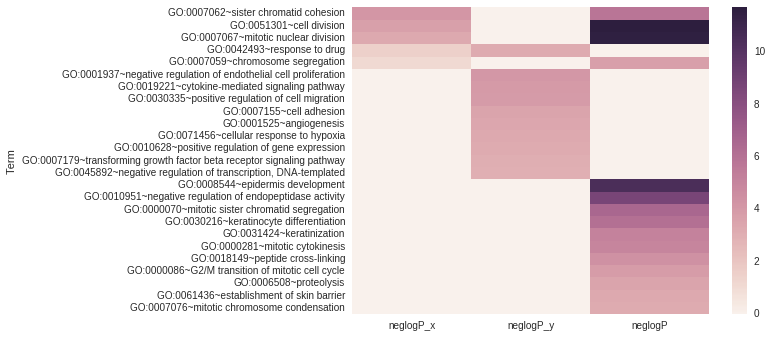

In [204]:
sns.set(font_scale=1)
heatmap = sns.heatmap(heatmap_df)

In [206]:
heatmap_file = heatmap.get_figure()
heatmap_file.savefig('gene_heatmap',bbox_inches='tight')